# Análisis de los contratos colombianos

El objeto de este notebook es mediante un ejemplo práctico poder realizar la aplicación de diferentes tecnologías para procesamiento y análisis de datos, usando datos públicos de un portal colombiano de contratación.

# Contexto del problema

No pretendo iniciar la discusión de si un lenguaje es mejor que otro, mi opinión es que simplemente cada herramienta esta construida para diferentes propósitos y cada quien elije la mejor que se adecue a su contexto y realidad, teniendo en cuenta lo anterior, escribo este notebook porque hace un par de meses no logré analizar el datapump generado por la herramienta: [Contra](https://github.com/dav009/contra), estaba haciendo uso del lenguaje R, pero por los recursos de mi máquina y teniendo en cuenta que R todo lo sube a memoria no logré realizar el análisis, ahora luego experimenté con Spark y logré el objetivo del procesamiento de los datos.

Es muy importante brindar los créditos a [David Przybilla](https://github.com/dav009/) porque debido a la herramienta [Contra](https://github.com/dav009/contra) es posible contar con este datapump el cual contiene mas de un millón de contratos con información muy relevante donde existe el potencial de realizar numerosos análisis muy pertienentes.

Un aspecto adicional es que no es necesario tener grandes datos, para poder experimentar con esta tecnologías, precisamente una de las premisas es que estas escalan de acuerdo al problema sin tener que hacer grandes cambios en la codificación, en pocas palabras la intención es animar al lector para que haga sus prácticas en su hogar u oficina y claro esta, cuando el problema cambie de escala, nuevos desafíos aparecen.

In [6]:
%%html
<style>
table {float:left}
</style>

# Arquitectura de solución

| Item              | Valor           |
|-------------------|-----------------|
| Memoria           | 16GB            |
| CPU               | AMD, 8 cores    |
| Almacenamiento    | 120GB SDD       |
| Sistema Operativo | Ubuntu16.04 LTS |

# Versión y configuración Spark

In [7]:
from pyspark.conf import SparkConf
print("Versión de Spark: %s" % (sc.version))
conf = SparkConf()
print(conf.toDebugString())

Versión de Spark: 1.6.1
spark.app.name=PySparkShell
spark.master=local[*]
spark.submit.deployMode=client


### Nota:

No es necesario tener estos mismos recursos, con menos puede funcionar, sin embargo son los que contaba en el momento de la práctica.

# ¿Qué es Spark?

Como muchos de los productos que existen Spark es el resultado de un proyecto de investigación de un estudiante(Matei Zaharia) de doctorado de la universidad de Berkely esta no solo ha producido Spark, sino todo lo contrario sus contribuciones son muchas en el ambito de la computación.

Spark es un motor de procesamiento general de datos a gran escala, eso dice su definición, sin embargo mas allá de eso, mejora algunas características del conocido Hadoop. En cuanto a su arquitectura, es ahí donde se encuentra lo interesante, tiene muchos componentes de patrones de diseño de software que favorecen la computación distribuida y de alto desempeño, implementado patrones como "lazy" para evaluación por demanda, en cuanto a los paradigmas de procesamiento de datos implementa el conocido algoritmo: map-reduce, Spark esta implementado sobre Scala así que ya por ende comparte todas las características de la máquina virtual de java, la forma de programar con spark, se puede hacer mediante el lenguaje Scala de manera nativa, pero también existen APIs que permiten la programación en Java, Python y R. Spark comprende diferentes módulos hasta abordar algoritmos de machine learning, módulo para trabajo con grafos y operaciones de datos de alto flujo (streaming).

Hoy por hoy el proyecto esta teniendo muy buena acogida y es mantenido por la Apache Software Foundation, organización que es un actor fundamental en todo el desarrollo y apalancamiento de todas las tecnologías para computación cognitiva.

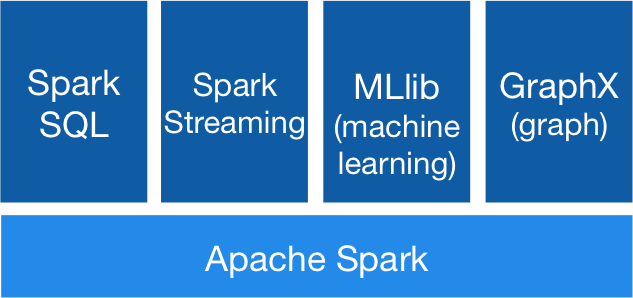

In [8]:
from IPython.display import Image
Image(filename='./images/spark-stack.png', width=600) 

# Enlaces útiles

[Co-creador Spark](https://people.csail.mit.edu/matei/)  
[Paper sobre RDD - (concepto fundamental en Spark)](https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final138.pdf)  
[Resilient Distributed Datasets: A Fault-Tolerant Abstraction for In-Memory Cluster Computing](https://www.usenix.org/conference/nsdi12/technical-sessions/presentation/zaharia)  
[Sitio oficial](http://spark.apache.org/)  
[Apache Spark Key Terms, Explained](https://databricks.com/blog/2016/06/22/apache-spark-key-terms-explained.html)  
[Canal en youtube](https://www.youtube.com/channel/UCRzsq7k4-kT-h3TDUBQ82-w)  
[Differences at shuffle side between Hadoop and Spark](http://people.eecs.berkeley.edu/~kubitron/courses/cs262a-F13/projects/reports/project16_report.pdf)  
[Spark for Python Developers](https://www.packtpub.com/big-data-and-business-intelligence/spark-python-developers)  
[Learning Spark](http://shop.oreilly.com/product/0636920028512.do)  
[Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do)  
[Genome Sequencing in a Nutshell
Part 1 of the Genome Variant Analysis using K-Means, ADAM, and Apache Spark Series](https://databricks.com/blog/2016/05/24/genome-sequencing-in-a-nutshell.html)  
[Apache Spark community](http://spark.apache.org/community.html)  
**Para explorar spark en la nube sin necesidad de instalarlo:**  
[Apache Spark on Datbricks for Data scientists](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/346304/2168141618055194/484361/latest.html)  
[Apache Spark for Data Engineers](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/346304/2168141618055109/484361/latest.html)

# Instalación de Spark

La instalación no tiene grandes complicaciones basta con seguir la guía que se encuentra en este libro: [Spark for Python Developers](https://www.packtpub.com/big-data-and-business-intelligence/spark-python-developers) ó cualquier otro recurso disponible.

Usando docker:  
[docker-stacks](https://github.com/jupyter/docker-stacks/tree/master/all-spark-notebook)

# Procesamiento de los datos (#DataEngineering)

Una vez el data pump se encuentra descomprimido lo primero que se debe hacer bajo la filosofía Spark es crear la estructura RDD, en este caso se dispone de un conjunto de datos que contiene información bajo el formato JSON, la simplicidad de código sorprende porque realmente con muy pocas líneas de código se obtiene la creación de la estructura.

In [9]:
import json
contract_path = "/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json"
# Creación del RDD
contract_rdd = sc.textFile(contract_path)
# Operación Map -> por cada registro hacer una lectura JSON
contract_json = contract_rdd.map(lambda x: json.loads(x))

In [10]:
contract_json.take(1)

[{'Correo Electrónico': 'MARIA.PALACIO@MEDELLIN.GOV.CO',
  'Creación de Proceso': '03 de November  de 2010  04:30 P.M.',
  'Cuantía Definitiva del Contrato': '$186,317,933     Peso Colombiano',
  'Cuantía a Contratar': '$186,317,933',
  'Departamento y Municipio de Ejecución': 'Antioquia : Medellín',
  'Detalle y Cantidad del Objeto a Contratar': 'PROMOVER EL FOMENTO DE LAS MUJERES RURALES DEL CORREGIMIENTO DE SAN SEBASTIAN DE PALMITAS -COMUNA 50- A TRAVES DE LA REALIZACIÓN DE ACTIVIDADES COMO ESTUDIO DE FACTIBILIDAD, DISEÑO DE UNA FIGURA DE PRODUCCIÓN Y COMERCIALIZACIÓN ASOCIADA  (MODELO EMPRESARIAL COMUNITARIO), PROGRAMACIÓN DE LA PRODUCCIÓN Y ESTABLECIMIENTO DE UNA ALIANZA PARA LA COMERCIALIZACIÓN DE PRODUCTOS DERIVADOS DE LAS ACTIVIDADES RURALES SEGÚN LAS DEFINE LA LEY DE MUJER RURAL, CONSIDERANDO EL ENTRENAMIENTO DE LIDERES Y BENEFICIANDO EL CORREGIMIENTO.',
  'Dirección Física del Contratista': 'CR 50 58 58 Municipio de Medellin',
  'Estado del Contrato': 'Liquidado',
  'Estado d

# Análisis del bloque de código anterior

**contract_rdd = sc.textFile("/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json")**

Creación de la estructura RDD (abstración primaria de Spark), recibe la ubicación del archivo JSON que contiene toda la información, aquí pueden ir también desde archivos planos hasta archivos en sistemas HDFS, el segundo parámetro 

Mas información sobre este método acá: http://spark.apache.org/docs/latest/programming-guide.html

**contract_json = contract_rdd.map(lambda x: json.loads(x))**

En spark se pueden llevar acabo dos tipos de procesos: acciones y transformaciones, en la linea de código anterior se realiza una transformación mediante el método map, quiere decir que por cada lectura de un registro en el datapump, se realizará una transformación a formato **JSON**, otro aspecto importante es la claúsula **lambda**, la cual permite incluir la invocación de una función de manera anónima, como se interpreta: x viene siendo cada registro del data pump, y lo que se quiere hacer es que a cada registro "x", se haga una lectura y carga a **JSON**.  es muy usual ver este constructo en las transformaciones con map, las transformaciones en Spark son con **patrón lazy**, es decir no se ejecutan inmediatamente, sino hasta que se invoque una acción.

[Acciones en spark](http://spark.apache.org/docs/latest/programming-guide.html#actions)  
[Transformaciones en Spark](http://spark.apache.org/docs/latest/programming-guide.html#transformations)  
[Acerca de la claúsula lambda](http://www.python-course.eu/lambda.php)  

**contract_json.take(1)**

Por último se invoca una acción que significa retornar uno de los registros **JSON** del data pump, las acciones tienen una característica y es que estan implementadas bajo **patrón lazy**, es decir que en este momento es donde se ejecuta un **job de spark** bajo el **contexto spark iniciado** para operar con el **RDD**, para retornar la información solicitada, visualizando la estructura **JSON** del primer dato.

[Mas información transformaciones y acciones](https://trongkhoanguyenblog.wordpress.com/2014/11/27/understand-rdd-operations-transformations-and-actions/)

# ¿Cuantos contratos hay?

In [11]:
format(contract_json.count(), ',d')

'2,150,626'

# Análisis del bloque de código anterior

De nuevo se ejecuta una claúsula de tipo acción, esto implica que los jobs de spark son ejecutados hasta terminar todos los jobs planeados.

Acá un segmento del log ofrecido por el shell de spark:

16/06/09 08:48:13 INFO TaskSetManager: Finished task 222.0 in stage 2.0 (TID 224) in 1259 ms on localhost (223/232)
16/06/09 08:48:13 INFO PythonRunner: Times: total = 1267, boot = 40, init = 34, finish = 1193
16/06/09 08:48:13 INFO Executor: Finished task 223.0 in stage 2.0 (TID 225). 2125 bytes result sent to driver
16/06/09 08:48:13 INFO TaskSetManager: Starting task 231.0 in stage 2.0 (TID 233, localhost, partition 231,PROCESS_LOCAL, 2186 bytes)
16/06/09 08:48:13 INFO TaskSetManager: Finished task 223.0 in stage 2.0 (TID 225) in 1274 ms on localhost (224/232)
16/06/09 08:48:13 INFO Executor: Running task 231.0 in stage 2.0 (TID 233)
16/06/09 08:48:13 INFO HadoopRDD: Input split: file:/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json:7

# Lectura de los datos usando un Data Frame

In [1]:
contract_path = "/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json"
df = sqlContext.read.json(contract_path)

# Análisis del bloque de código anterior

Existen diferentes maneras de empezar a realizar la exploración de datos en Spark, sin embargo como una parte de la arquitectura vista en la imagen anterior se puede apreciar que existe un modulo especializado de **SQL Spark** el cual esta pensado y optimizado para exploración de datos, en especial la interacción de datos en formato **JSON**.

En los siguientes enlaces estan las razones y caracteristicas para usar **Spark SQL**

[Paper-Spark SQL: Relational Data Processing in Spark](https://amplab.cs.berkeley.edu/wp-content/uploads/2015/03/SparkSQLSigmod2015.pdf)  
[An introduction to JSON support in Spark SQL](https://databricks.com/blog/2015/02/02/an-introduction-to-json-support-in-spark-sql.html)  
[Apache Spark: RDD, DataFrame or Dataset](http://www.kdnuggets.com/2016/02/apache-spark-rdd-dataframe-dataset.html/2)  
[Data Exploration Using Spark SQL](https://databricks-training.s3.amazonaws.com/data-exploration-using-spark-sql.html)  

Spark recomienda utilizar los dataframes, es la estructura óptima para el procesamiento de datos y no tiene penalidad en el procesamiento usando como API de programación el lenguaje python, como en el caso de los RDD si se usa python el tiempo en operaciones de map-reduce se puede ver degradado.

Mas información acá:

[RDDs, DataFrames and Datasets in Apache Spark - NE Scala 2016](https://www.youtube.com/watch?v=pZQsDloGB4w)  
[Introducing DataFrames in Apache Spark for Large Scale Data Science](https://databricks.com/blog/2015/02/17/introducing-dataframes-in-spark-for-large-scale-data-science.html)

# Descripción del esquema de datos archivo JSON

In [13]:
df.printSchema()

root
 |-- Actividades o servicios prestados por el inversionista: string (nullable = true)
 |-- Adición al contrato: string (nullable = true)
 |-- Adjudicación: string (nullable = true)
 |-- Beneficios e impactos: string (nullable = true)
 |-- Calificación definitiva de los proponentes - Orden de elegibilidad: string (nullable = true)
 |-- Causal de Otras Formas de Contratación Directa: string (nullable = true)
 |-- Celebración de Contrato: string (nullable = true)
 |-- Clase: string (nullable = true)
 |-- Convocatoria: string (nullable = true)
 |-- Correo Electrónico: string (nullable = true)
 |-- Correo Electrónico para el Envío de Expresiones: string (nullable = true)
 |-- Creación de Proceso: string (nullable = true)
 |-- Cuantía Definitiva del Contrato: string (nullable = true)
 |-- Cuantía a Contratar: string (nullable = true)
 |-- Departamento y Municipio de Ejecución: string (nullable = true)
 |-- Departamento y Municipio de Entrega Documentos: string (nullable = true)
 |-- Dep

# Cantidad de contratos por departamento (#DataExploration)

In [14]:
df_pandas = df.groupBy("Departamento y Municipio de Ejecución").count().toPandas()

In [15]:
df_pandas.head(20)

,Departamento y Municipio de Ejecución,count
0,Arauca : Tame,2179
1,Bolívar : Arroyohondo,258
2,Nariño : Belén,1032
3,Valle del Cauca : Buenaventura,6567
4,Santander : Encino,600
5,"Bolívar : Córdoba, El Carmen de Bolívar, Magan...",1
6,"Cauca : Miranda, Caloto, Santander de Quilicha...",1
7,"Cesar : La Jagua de Ibirico, Becerril, Pueblo ...",37
8,"Boyacá : Guateque, SogamosoCasanare : YopalBoy...",5
9,"Cauca : Popayán, Totoró",7


# Análisis del bloque de código anterior

Una primera aproximación en exploración de datos es conocer la cantidad de contratos por departamento, sin embargo los datos no estan categorizados por departamento en cambio en un mismo atributo se encuentran los datos de departamento y municipio, esto ya conlleva a la solución de ajuste de datos, por ahora no se va a transformar nada, pero si se hace el uso de una libreria muy utilizada y útil en el ecosistema para tratamiento de datos con **Python** esta libreria se llama **Pandas** como hemos realizado una operación de agrupación, mediante un método del dataframe se realiza una transformación del producto de la agrupación a un **dataframe pandas** esto va a ser muy útil porque inmediatamente se cuenta con la posibilidad de hacer todas las operaciones proporcionadas por el framework y en un apartado posterior también servirá para realizar la visualización de los datos.

[Pandas sitio oficial](http://pandas.pydata.org/)  
[python pandas data analysis](https://pythonprogramming.net/python-pandas-data-analysis/)  
[Pandas Cookbook](http://nbviewer.jupyter.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%204%20-%20Find%20out%20on%20which%20weekday%20people%20bike%20the%20most%20with%20groupby%20and%20aggregate.ipynb)

# Cantidad de contratos por departamento (#DATAVIZ)

In [2]:
%matplotlib inline
import seaborn as sns

In [17]:
con_dep_top_20 = df_pandas.sort_values(by='count', ascending=0).head(20)

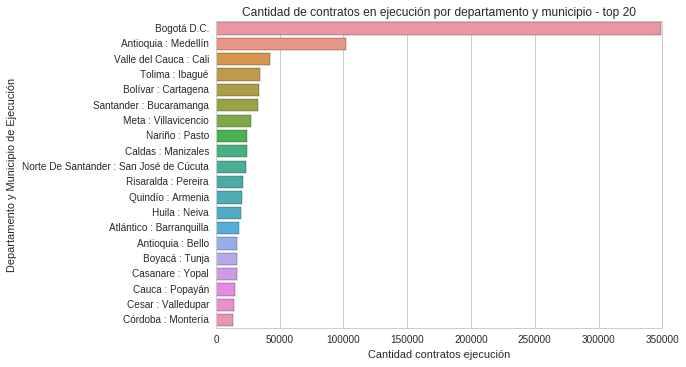

In [18]:
sns.set(style="whitegrid", color_codes=True)
sns.plt.title('Cantidad de contratos en ejecución por departamento y municipio - top 20')
plot = sns.barplot(x="count", y="Departamento y Municipio de Ejecución", data=con_dep_top_20)
plot.set(xlabel='Cantidad contratos ejecución')

# Cantidad de contratos por tipo de contrato

In [19]:
df_pandas_tipo_con = df.groupBy("Tipo de Contrato").count().toPandas()
df_pandas_tipo_con = df_pandas_tipo_con.sort_values(by='count', ascending=0)

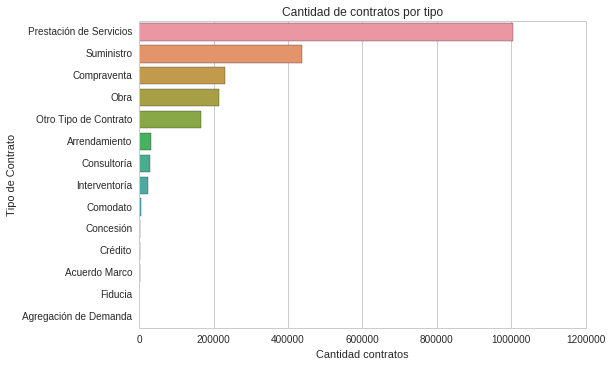

In [20]:
sns.plt.title('Cantidad de contratos por tipo')
plot = sns.barplot(x="count", y="Tipo de Contrato", data=df_pandas_tipo_con)
plot.set(xlabel='Cantidad contratos')

# Cantidad de contratos por estado

In [21]:
df_pandas_est_con = df.groupBy("Estado del Contrato").count().toPandas()
df_pandas_est_con = df_pandas_est_con.sort_values(by='count', ascending=0)

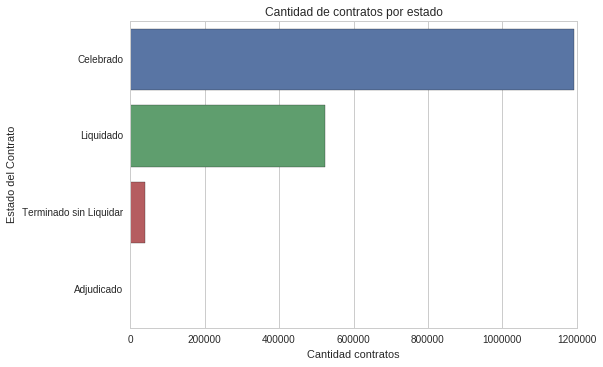

In [22]:
sns.plt.title('Cantidad de contratos por estado')
plot = sns.barplot(x="count", y="Estado del Contrato", data=df_pandas_est_con)
plot.set(xlabel='Cantidad contratos')

# Limpieza de datos y transformación

In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def cleanQuantity(quantity):
    n_quantity = str(quantity).replace("$","")
    n_quantity = n_quantity.replace(",", "")
    n_quantity = n_quantity.replace("Peso Colombiano", "")
    n_quantity = n_quantity.replace(" ", "")
    return n_quantity

udfCleanQuantity = udf(cleanQuantity, StringType())

# Análisis del bloque de código anterior

Como es usual en un **pipeline** de ciencia de datos, se deben hacer muchas operaciones de limpieza y agrupación de datos, normalmente según literatura esto es lo que mas tiempo conlleva en lo proyectos de datos (principio de Pareto 80-20), puede que implique realizar muchas líneas de código y ocupar buen tiempo y recursos de software y hardware.

En el dataset que se esta analizando el valor de cuantía tiene caracteres adicionales (ejemplo: "$186,317,933     Peso Colombiano") que imposibilita poder realizar operaciones aritméticas, así que antes de esto se debe limpiar la cadena donde esta contenido el número, como todo en programación y algoritmia existen diversas formas de hacer esto y un camino es atraves de UDF(user defined functions) el cual es una implementación de Spark que se puede usar en los dataframes, para aplicar cualquier función definida sobre cualquier columna que se proyecta en un dataframe, produciendo una transformación cualquiera, hay que tener en cuenta que SQLSpark ya cuenta con unas funciones predefinidas, así que antes de usar un UDF revisar si ya existe algo implementado.

Mas información:

[Spark: Custom UDF Example](https://ragrawal.wordpress.com/2015/10/02/spark-custom-udf-example/)  
[pyspark.sql.functions.udf](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=udf#pyspark.sql.functions.udf)



In [24]:
df_clean = (df.select(df['Departamento y Municipio de Ejecución']
              .alias('dep_mun_ejec'), 
               udfCleanQuantity(df['Cuantía Definitiva del Contrato'])
              .alias('cuantia')))

In [25]:
df_clean = df_clean.select(df_clean.dep_mun_ejec, df_clean.cuantia.cast("Int"))

df_pandas_clean = (df_clean.filter(df_clean.dep_mun_ejec.isNotNull())
                           .filter(df_clean.cuantia > 0)
                           .groupBy("dep_mun_ejec").sum("cuantia")
                           .toPandas()
                           .sort_values(by='sum(cuantia)', ascending=0)
                           .head(20))

# Monto cuantias definitivas por departamento - ciudad - top 20

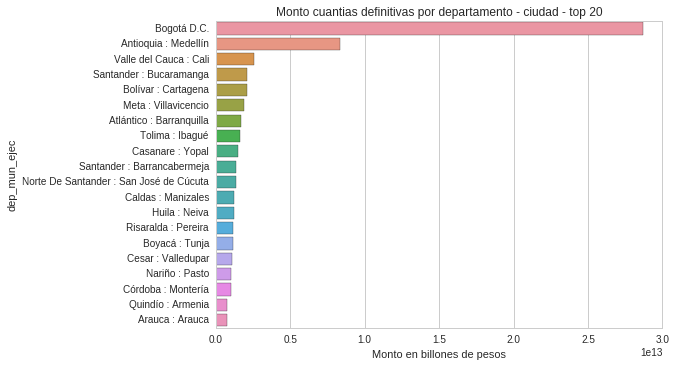

In [26]:
sns.plt.title('Monto cuantias definitivas por departamento - ciudad - top 20')
plot = sns.barplot(x="sum(cuantia)", y="dep_mun_ejec", data=df_pandas_clean)
plot.set(xlabel='Monto en billones de pesos')

# Cantidad de contratos por contratista - Top 20

In [27]:
df_pandas_contratista = df.groupBy("Nombre o Razón Social del Contratista").count().toPandas()
df_pandas_contratista = df_pandas_contratista.sort_values(by='count', ascending=0).head(20)

In [28]:
df_pandas_contratista

,Nombre o Razón Social del Contratista,count
693558,None,394186
69509,ASEGURADORA SOLIDARIA DE COLOMBIA,1107
20513,SERVICIOS POSTALES NACIONALES S.A.,965
697742,UNIVERSIDAD NACIONAL DE COLOMBIA,956
155735,R.P DENTAL S.A,937
77604,SUPLEMEDICOS S.A,937
681324,UNIVERSIDAD DE ANTIOQUIA,902
402420,IMPRENTA NACIONAL DE COLOMBIA,882
517545,COOPERATIVA DE HOSPITALES DE ANTIOQUIA,871
402411,DISDROBLAN S.A,862


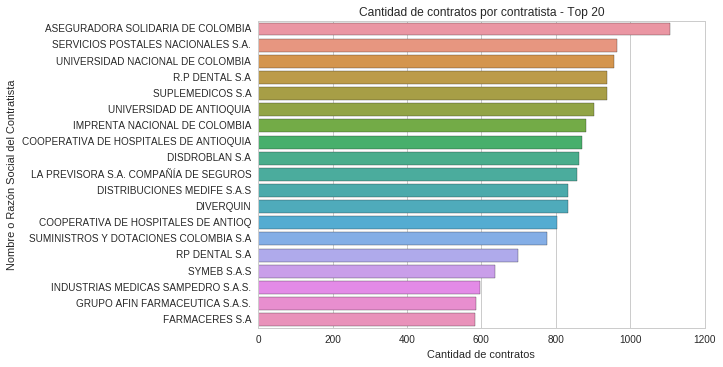

In [29]:
sns.plt.title('Cantidad de contratos por contratista - Top 20')
plot = sns.barplot(x="count", y="Nombre o Razón Social del Contratista", data=df_pandas_contratista)
plot.set(xlabel='Cantidad de contratos')

# Monto cuantias definitivas por tipo de contrato

In [30]:
df_clean_tc = (df.select(df['Tipo de Contrato']
              .alias('tipo_contrato'), 
               udfCleanQuantity(df['Cuantía Definitiva del Contrato'])
              .alias('cuantia')))
     
df_clean_tc = df_clean_tc.select(df_clean_tc.tipo_contrato, df_clean_tc.cuantia.cast("Int"))

df_pandas_clean_tc = (df_clean_tc.filter(df_clean_tc.tipo_contrato.isNotNull())
                           .groupBy("tipo_contrato").sum("cuantia")
                           .toPandas()
                           .sort_values(by='sum(cuantia)', ascending=0)
                     )

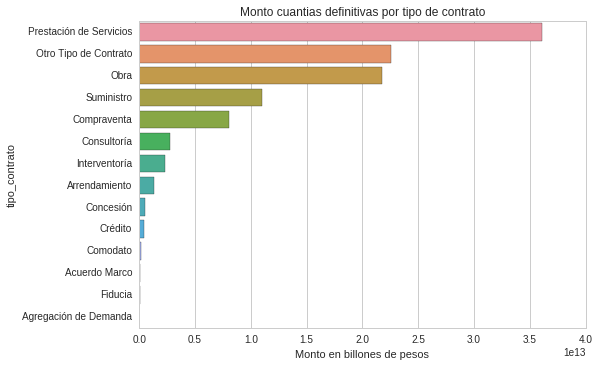

In [31]:
sns.plt.title('Monto cuantias definitivas por tipo de contrato')
plot = sns.barplot(x="sum(cuantia)", y="tipo_contrato", data=df_pandas_clean_tc)
plot.set(xlabel='Monto en billones de pesos')

# Agrupación por plazo de ejecución - top 20

In [32]:
df_pandas_plazo_eje = df.groupBy("Plazo de Ejecución del Contrato").count().toPandas()
df_pandas_plazo_eje = df_pandas_plazo_eje.sort_values(by='count', ascending=0).head(20)

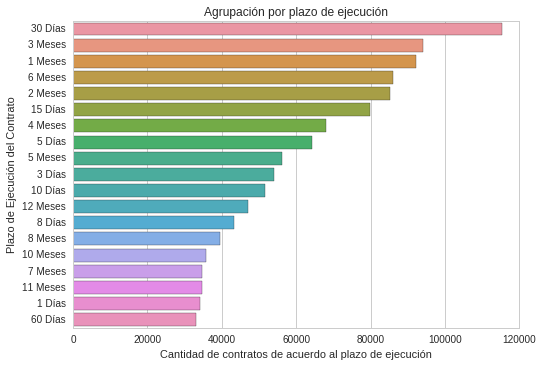

In [33]:
sns.plt.title('Agrupación por plazo de ejecución')
plot = sns.barplot(x="count", y="Plazo de Ejecución del Contrato", data=df_pandas_plazo_eje)
plot.set(xlabel='Cantidad de contratos de acuerdo al plazo de ejecución')

# ¿Cuantas palabras existen en la descripción de todos los contratos?

In [25]:
from pyspark.sql.functions import regexp_replace, trim, col, lower
def removePunctuation(column):
    """Remueve puntuación, se transforma a minúsculas, se eliminan espacios en blanco al principio.

    Nota:
        Solo espacios, letras y números serán retenidos.

    Argumentos:
        columna (Column): Cadena.

    Retorno:
        Columna: Cadena con la transformación
    """
    return trim(lower(regexp_replace(column,'[^a-zA-Z0-9\s]+','')))

In [22]:
from pyspark.sql.functions import split, explode, col

cleanLines = df.select(removePunctuation(col('Objeto del Contrato')).alias('Objeto del Contrato'))
wordsDF = (cleanLines
           .select(explode(split(col('Objeto del Contrato'), '\s')).alias('word'))
          )

In [26]:
format(wordsDF.count(), ',d')

'55,942,043'

In [ ]:
from stop_words import get_stop_words
stop_words = get_stop_words('spanish')
df_words_top_20 = wordsDF.groupBy("word").count().toPandas()
df_words_top_20 = df_words_top_20[df_words_top_20["word"] != ""]
df_words_top_20 = df_words_top_20[~df_words_top_20.word.isin(stop_words)]
df_words_top_20 = df_words_top_20.sort_values(by='count', ascending=0).head(20)

# Cantidad de palabras mas frecuentes - objeto de contratos - top 20

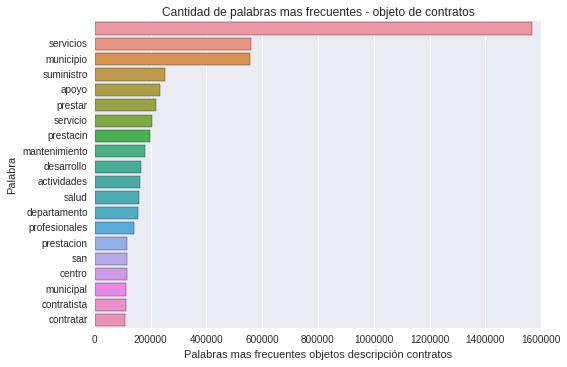

In [30]:
sns.plt.title('Cantidad de palabras mas frecuentes - objeto de contratos')
plot = sns.barplot(x="count", y="word", data=df_words_top_20)
plot.set(xlabel='Palabras mas frecuentes objetos descripción contratos')
plot.set(ylabel='Palabra')

# Cantidad de contratos que en su objeto contienen la palabra "software"

In [38]:
from pyspark.sql.functions import *
format(df.select(df["Objeto del Contrato"])
         .filter(lower(df["Objeto del Contrato"])
                 .like("%software%")).count(), ",d")
                            

'12,419'

# Total país cuantias contratos que contienen la palabra software

In [39]:
df_clean_quantity = (df.select(df["Objeto del Contrato"], udfCleanQuantity(df['Cuantía Definitiva del Contrato'])
                       .alias('cuantia').cast("int"))
                       .filter(lower(df["Objeto del Contrato"])
                               .like("%software%")))
     
df_clean_quantity.select(sum(df_clean_quantity["cuantia"])).show()

+-------------+
| sum(cuantia)|
+-------------+
|1063855285754|
+-------------+



# Distribución cuantias a nivel país

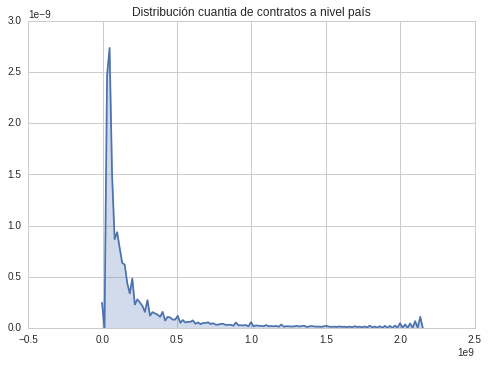

In [40]:
sns.plt.title('Distribución cuantia de contratos a nivel país')
sns.distplot(df_clean.select(df_clean.cuantia)
                     .filter(df_clean.cuantia > 0)
                     .collect(), hist=False, color="b", kde_kws={"shade": True})